# 1. Preparing the data


In [1]:
from modules import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import  make_classification
from mlp_module import MLP


# Load the dataset

# data = load_breast_cancer()
# X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X,y = make_classification(n_samples=1000, n_features=2, n_informative=2,n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,class_sep=1.5, random_state=17)

# X, y = data.data, data.target


# Normalize the dataset
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

trained = False

Training data shape: (800, 2)
Testing data shape: (200, 2)


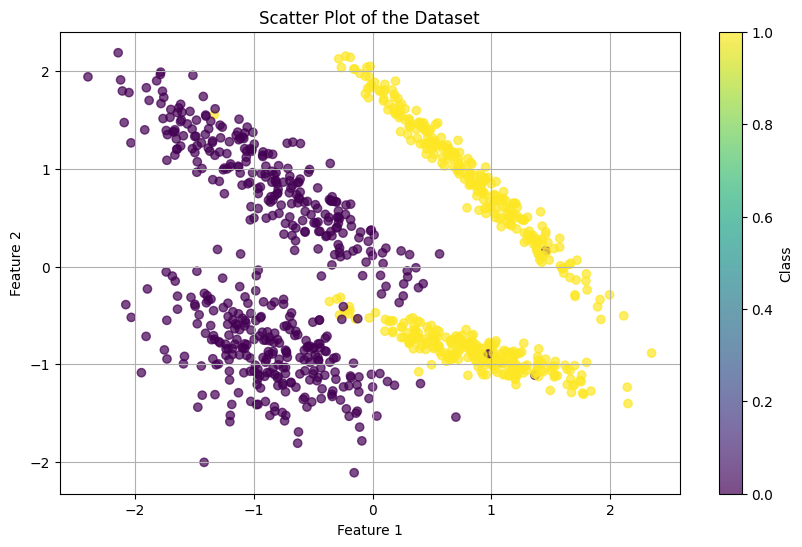

In [2]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of the Dataset')
plt.grid(True)
plt.show()

# 2. Praparing MLP and loss func

In [3]:
class MLPClassifier(MLP):

    def __init__(self, layers, epochs=1000, lr=0.01, input_shape=1, output_shape=1):
        super().__init__(layers, epochs, lr, input_shape, output_shape)
        self.threshold = 0.5
        
    def get_loss(self, y_pred, y_true):
        y_pred = y_pred.reshape(-1, 1)
        # Clip predictions to prevent log(0)
        y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
        # Compute cross-entropy loss
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def get_loss_grad(self, y_pred, y_true):
        # The loss here is the cross-entropy loss
        # It accepts matrix with the shape (x, n_classes)
        # Where x is the number of samples and n_classes is the number of classes
        
        y_pred = y_pred.reshape(-1, 1)
        # Clip predictions to prevent division by zero
        y_pred = np.clip(y_pred, 1e-12, 1. - 1e-12)
        # Compute gradient of cross-entropy loss
        return (y_pred - y_true) / (y_pred * (1 - y_pred))
    
    def predict(self, X):
        # Forward pass
        y_pred = self.forward(X)
        
        # Convert the output to binary
        return (y_pred > self.threshold).astype(int)

    
    

In [4]:
layers = [
        Linear(input_size=2, output_size=64),
        ReLU(),
        Linear(input_size=64, output_size=128),
        ReLU(),
        # Linear(input_size=128, output_size=256),
        # ReLU(),
        Linear(input_size=128, output_size=1),
        Sigmoid()
    ]


# 3. Training and visualizing the results

In [5]:
# Create an instance of the MLPClassifier

epochs = 2000
lr = 0.1

mlp = MLPClassifier(layers, epochs=epochs, lr=lr, input_shape=X_train.shape[1])
if not trained:
    # Train the model with the generated data
    mlp.train_MBGD(X_train, y_train)
    trained = True
elif trained:
    mlp.reset()
    mlp.train_MBGD(X_train, y_train)


Training MBGD:   0%|          | 0/2000 [00:00<?, ?it/s]

Training MBGD: 100%|██████████| 2000/2000 [00:31<00:00, 62.82it/s] 


# 4. Training Results and Evaluation

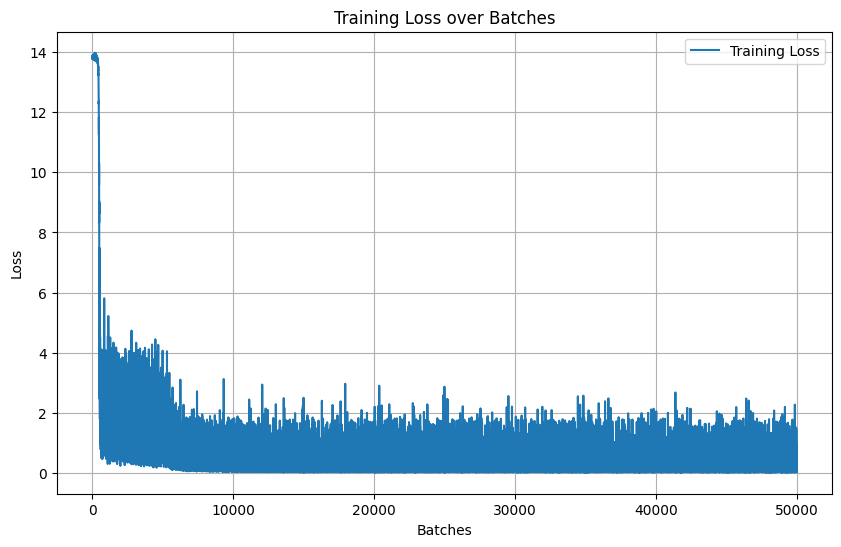

In [6]:
# %%script true
loss_history = mlp.loss
length = len(loss_history)

# Plot the loss history
plt.figure(figsize=(10, 6))
plt.plot(range(length), loss_history, label='Training Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.title('Training Loss over Batches')
plt.legend()
plt.grid(True)
plt.show()

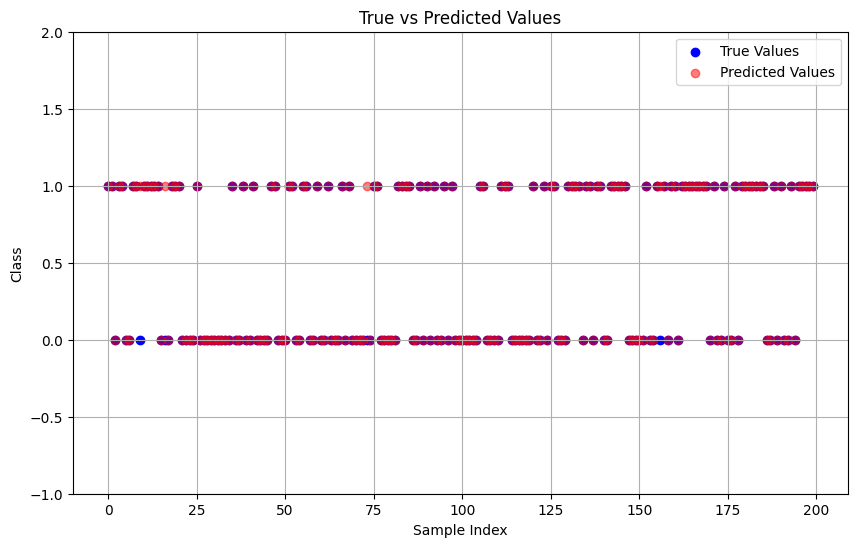

In [7]:
# %%script true
# Perform inference on the test dataset
y_pred = mlp.predict(X_test)

# Print the predicted values
# print(y_pred)
# Visualize the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='True Values')
plt.scatter(range(len(y_test)), y_pred, color='red', alpha=0.5, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.ylim(-1, 2)
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
epochs = 2000
lr = 0.01

eval_layers = [
        Linear(input_size=2, output_size=64),
        ReLU(),
        Linear(input_size=64, output_size=128),
        ReLU(),
        Linear(input_size=128, output_size=1),
        Sigmoid()
    ]

# Creates the model    
model_evaluation = MLPClassifier(eval_layers, epochs=epochs, lr=lr, input_shape=2)
if not trained:
    # Train the model with the generated data
    model_evaluation.train_k_fold(X, y, k=5, epochs=epochs, lr=lr)
    trained = True
elif trained:
    model_evaluation.reset()
    model_evaluation.train_k_fold(X,y,k=5, epochs=epochs, lr=lr)

Training MBGD: 100%|██████████| 2000/2000 [00:06<00:00, 299.30it/s]


Fold 1, Loss: 0.49298500216657515


Training MBGD: 100%|██████████| 2000/2000 [00:06<00:00, 286.67it/s]


Fold 2, Loss: 0.8965412981047416


Training MBGD: 100%|██████████| 2000/2000 [00:06<00:00, 295.98it/s]


Fold 3, Loss: 0.7030396145323955


Training MBGD: 100%|██████████| 2000/2000 [00:06<00:00, 296.54it/s]


Fold 4, Loss: 0.6994455300923764


Training MBGD: 100%|██████████| 2000/2000 [00:06<00:00, 298.55it/s]

Fold 5, Loss: 0.5718223008831487


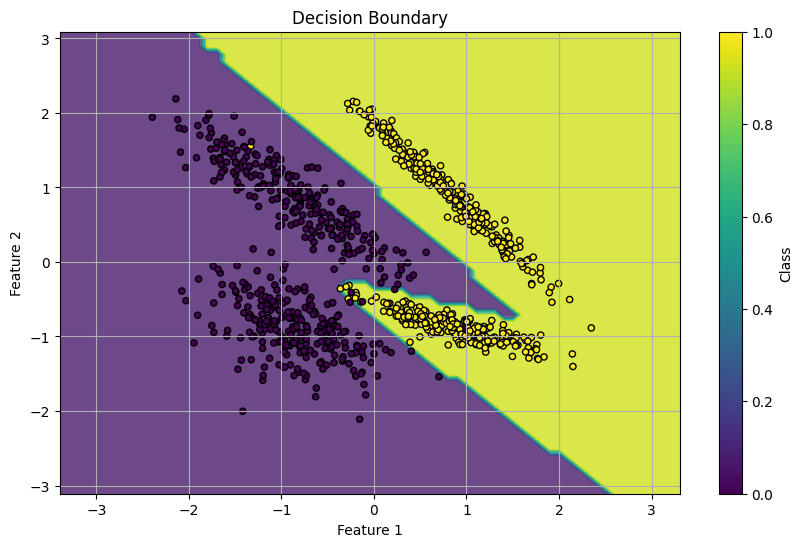

In [11]:
# Define the mesh grid
h = 0.1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class for each point in the grid
Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=20)
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary')
plt.grid(True)
plt.show()

In [12]:
def calculate_accuracy(y_actual, y_pred):

    correct_predictions = 0
    total_predictions = len(y_actual) # 其实y_actual和y_pred的长度是一样的

    for i in range(total_predictions):
        if y_actual[i] == y_pred[i]:
            correct_predictions += 1

    return correct_predictions / total_predictions

def calculate_recall(y_actual, y_pred, positive_label=1):
    true_positive = 0
    false_negative = 0

    for i in range(len(y_actual)):
        if y_actual[i] == positive_label:
            if y_pred[i] == positive_label:
                true_positive += 1
            else:
                false_negative += 1

    recall = true_positive / (true_positive + false_negative)
    # tp + fn 为真值的总数
    return recall

def calculate_precision(y_actual, y_pred, positive_label=1):
    true_positive = 0
    false_positive = 0

    for i in range(len(y_actual)):
        if y_pred[i] == positive_label:
            if y_actual[i] == positive_label:
                true_positive += 1
            else:
                false_positive += 1

    precision = true_positive / (true_positive + false_positive)
    # 在预测为正的情况下，有多少是真的正值
    # 如果模型过多地判定正值，那么recall会很高，但是precision会很低
    # 如果模型过多地判定负值，那么recall会很低，但是在判定为真值的样本里真值往往更多。（过于保守）
    
    return precision

def calculate_f1_score(y_actual, y_pred, positive_label=1):
    precision = calculate_precision(y_actual, y_pred, positive_label)
    recall = calculate_recall(y_actual, y_pred, positive_label)

    f1_score = 2 * precision * recall / (precision + recall)
    # 理想值是precision = 1, recall = 1.
    # 在两者数量相等的时候，f1_score比较高。
    return f1_score

y_pred = model_evaluation.predict(X_test)
accuracy = calculate_accuracy(y_test, y_pred)
recall = calculate_recall(y_test, y_pred)
precision = calculate_precision(y_test, y_pred)
f1_score = calculate_f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.975
Recall: 1.0
Precision: 0.9484536082474226
F1 Score: 0.9735449735449735


In [13]:
avg_val_loss = np.mean(model_evaluation.validation_loss)
print(f'Average validation loss: {avg_val_loss}')
print(f'Hyperparameters are: Epochs: {epochs}, LR: {lr}')
print("Model structure:")
for i, layer in enumerate(eval_layers):
    print(f"Layer {i + 1}: {layer.__class__.__name__}",end='')
    if isinstance(layer, Linear):
        print(f"Input size: {layer.input_size}, Output size: {layer.output_size}")
    else:
        print()

Average validation loss: 0.6727667491558476
Hyperparameters are: Epochs: 2000, LR: 0.01
Model structure:
Layer 1: LinearInput size: 2, Output size: 64
Layer 2: ReLU
Layer 3: LinearInput size: 64, Output size: 128
Layer 4: ReLU
Layer 5: LinearInput size: 128, Output size: 1
Layer 6: Sigmoid
